In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install transformers 

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from transformers import TFAutoModel, BertTokenizer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import f1_score, hamming_loss, classification_report
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Loading data
df_pub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Data/train_test_data/bert_pub_train.csv')
df_bias = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Data/train_test_data/bert_bias_train.csv')

In [5]:
# Creating masks for our dfs

#defining the sequence length
seq_len = 512

# creating masks and ids for publication model
num_samples_pub = len(df_pub)
Xids_pub = np.zeros((num_samples_pub, seq_len))
Xmask_pub = np.zeros((num_samples_pub, seq_len))

# creating masks and ids for bias model
num_samples_bias = len(df_bias)
Xids_bias = np.zeros((num_samples_bias, seq_len))
Xmask_bias = np.zeros((num_samples_bias, seq_len))


In [6]:
# loading in the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenizing all of the articles in the content for the publication model 
for i, content in enumerate(df_pub['content']):
  tokens_pub = tokenizer.encode_plus(content, max_length = seq_len, truncation = True,
                                padding = 'max_length', add_special_tokens = True,
                                 return_tensors = 'tf')
  Xids_pub[i, :] = tokens_pub['input_ids']
  Xmask_pub[i, :] = tokens_pub['attention_mask']

# tokenizing all of the articles in the content for the bias model 
for i, content in enumerate(df_bias['content']):
  tokens_bias = tokenizer.encode_plus(content, max_length = seq_len, truncation = True,
                                padding = 'max_length', add_special_tokens = True,
                                 return_tensors = 'tf')
  Xids_bias[i, :] = tokens_bias['input_ids']
  Xmask_bias[i, :] = tokens_bias['attention_mask']

In [7]:
# creating an array of the publication values for our tokenized content
arr_pub = df_pub['publication'].values
arr_bias = df_bias['bias'].values

In [8]:
# creating the labels for our tokenized content
labels_pub = np.zeros((num_samples_pub, arr_pub.max()+1))
labels_bias = np.zeros((num_samples_bias, arr_bias.max()+1))

In [9]:
# one hot encoding our publication
labels_pub[np.arange(num_samples_pub), arr_pub] = 1
labels_bias[np.arange(num_samples_bias), arr_bias] = 1

In [10]:
# creating dataset object for tf
dataset_pub = tf.data.Dataset.from_tensor_slices((Xids_pub, Xmask_pub, labels_pub))
dataset_bias = tf.data.Dataset.from_tensor_slices((Xids_bias, Xmask_bias, labels_bias))

In [11]:
# function to map our inputs together
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [12]:
# applying transformation to dataset for our model
dataset_pub = dataset_pub.map(map_func)
dataset_bias = dataset_bias.map(map_func)

In [13]:
# creating our batch size, would like to do bigger but have processing limitations
batch_size = 8

# shuffling our data, drop any samples that don't fit into batchsize 4
dataset_pub = dataset_pub.shuffle(26000).batch(batch_size, drop_remainder = True)
dataset_bias = dataset_bias.shuffle(12500).batch(batch_size, drop_remainder = True)

In [14]:
# setting our training and testing split size
split = .9

size_pub = int((num_samples_pub/batch_size)*split) 
size_bias = int((num_samples_bias/batch_size)*split) 

In [15]:
# creating our training and testing sets
train_ds_pub = dataset_pub.take(size_pub)
val_ds_pub = dataset_pub.skip(size_pub)

train_ds_bias = dataset_bias.take(size_bias)
val_ds_bias = dataset_bias.skip(size_bias)


In [16]:
# importing out BERT model
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
#creating our first model, there are two input layers
input_ids_pub = tf.keras.layers.Input(shape = (seq_len), name = 'input_ids', dtype = 'int32')
mask_pub = tf.keras.layers.Input(shape = (seq_len), name = 'attention_mask', dtype = 'int32')

# accessing our transformer model
embeddings_pub = bert.bert(input_ids_pub, attention_mask = mask_pub)[1]

# creating our neural network, use a dropout layer to prevent overfitting 
x_pub = tf.keras.layers.Dense(8192, activation='relu')(embeddings_pub) 
x_pub = tf.keras.layers.Dropout(rate = .5)(x_pub)
y_pub = tf.keras.layers.Dense(arr_pub.max()+1, activation = 'softmax', name = 'outputs')(x_pub)

In [18]:
#creating our second bias model
input_ids_bias = tf.keras.layers.Input(shape = (seq_len), name = 'input_ids', dtype = 'int32')
mask_bias = tf.keras.layers.Input(shape = (seq_len), name = 'attention_mask', dtype = 'int32')

embeddings_bias = bert.bert(input_ids_bias, attention_mask = mask_bias)[1]

x_bias = tf.keras.layers.Dense(8192, activation='relu')(embeddings_bias) 
x_bias = tf.keras.layers.Dropout(rate = .5)(x_bias)
y_bias = tf.keras.layers.Dense(arr_bias.max()+1, activation = 'softmax', name = 'outputs')(x_bias)

In [19]:
# initializing publication model
model_pub = tf.keras.Model(inputs = [input_ids_pub, mask_pub], outputs = y_pub)


In [20]:
# initializing bias model
model_bias = tf.keras.Model(inputs = [input_ids_bias, mask_bias], outputs = y_bias)


In [21]:
# setting our training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [22]:
# compiling our models
model_pub.compile(optimizer=optimizer, loss = loss, metrics = [acc])
model_bias.compile(optimizer=optimizer, loss = loss, metrics = [acc])

In [23]:
# fitting our publication model
history_pub = model_pub.fit(
    train_ds_pub,
    validation_data = val_ds_pub,
    epochs= 6
)

Epoch 1/6
4387/4387 [==============================] - 2496s 566ms/step - loss: 1.0264 - accuracy: 0.6597 - val_loss: 0.4559 - val_accuracy: 0.8514
Epoch 2/6
4387/4387 [==============================] - 2482s 566ms/step - loss: 0.4134 - accuracy: 0.8655 - val_loss: 0.3066 - val_accuracy: 0.9027
Epoch 3/6
4387/4387 [==============================] - 2481s 565ms/step - loss: 0.2777 - accuracy: 0.9110 - val_loss: 0.1623 - val_accuracy: 0.9465
Epoch 4/6
4387/4387 [==============================] - 2484s 566ms/step - loss: 0.1877 - accuracy: 0.9387 - val_loss: 0.1287 - val_accuracy: 0.9567
Epoch 5/6
4387/4387 [==============================] - 2487s 567ms/step - loss: 0.1296 - accuracy: 0.9575 - val_loss: 0.0550 - val_accuracy: 0.9826
Epoch 6/6
4387/4387 [==============================] - 2487s 567ms/step - loss: 0.0974 - accuracy: 0.9679 - val_loss: 0.0321 - val_accuracy: 0.9880


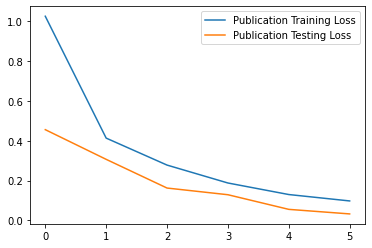

In [24]:
# plot publication loss
plt.plot(history_pub.history['loss'], label = 'Publication Training Loss')
plt.plot(history_pub.history['val_loss'], label = 'Publication Testing Loss')
plt.legend();


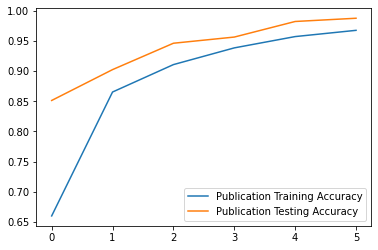

In [25]:
# plot publication accuracy
plt.plot(history_pub.history['accuracy'], label = 'Publication Training Accuracy')
plt.plot(history_pub.history['val_accuracy'], label = 'Publication Testing Accuracy')
plt.legend();

In [26]:
# fitting our bias model
history_bias = model_bias.fit(
    train_ds_bias,
    validation_data = val_ds_bias,
    epochs= 6
)

Epoch 1/6
1406/1406 [==============================] - 808s 568ms/step - loss: 0.2272 - accuracy: 0.9372 - val_loss: 0.0885 - val_accuracy: 0.9704
Epoch 2/6
1406/1406 [==============================] - 797s 567ms/step - loss: 0.1228 - accuracy: 0.9579 - val_loss: 0.0376 - val_accuracy: 0.9904
Epoch 3/6
1406/1406 [==============================] - 797s 567ms/step - loss: 0.0702 - accuracy: 0.9758 - val_loss: 0.0565 - val_accuracy: 0.9800
Epoch 4/6
1406/1406 [==============================] - 796s 566ms/step - loss: 0.0584 - accuracy: 0.9799 - val_loss: 0.0169 - val_accuracy: 0.9952
Epoch 5/6
1406/1406 [==============================] - 797s 567ms/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.0184 - val_accuracy: 0.9968
Epoch 6/6
1406/1406 [==============================] - 797s 567ms/step - loss: 0.0414 - accuracy: 0.9870 - val_loss: 0.0103 - val_accuracy: 0.9968


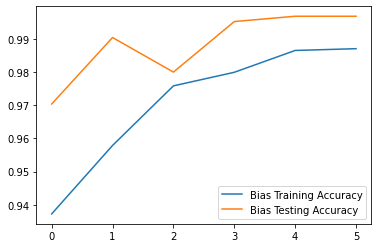

In [27]:
# plot bias accuracy 
plt.plot(history_bias.history['accuracy'], label = 'Bias Training Accuracy')
plt.plot(history_bias.history['val_accuracy'], label = 'Bias Testing Accuracy')
plt.legend();

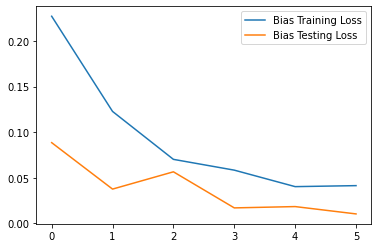

In [28]:
# plot bias loss
plt.plot(history_bias.history['loss'], label = 'Bias Training Loss')
plt.plot(history_bias.history['val_loss'], label = 'Bias Testing Loss')
plt.legend();

In [29]:
# saving our models 
model_pub.save('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/publication_model_test')
model_bias.save('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/bias_model_test')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/publication_model_test/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/publication_model_test/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/bias_model_test/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/bias_model_test/assets


In [30]:
# function to prep our test data
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
  tokens = tokenizer.encode_plus(text, max_length=512,
                                 truncation = True, padding ='max_length',
                                 add_special_tokens = True, return_token_type_ids = False,
                                 return_tensors = 'tf')
  
  return {
      'input_ids': tf.cast(tokens['input_ids'], tf.float64),
      'attention_mask': tf.cast(tokens['attention_mask'], tf.float64),
  }

In [31]:
# loading our saved models
new_model_pub = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/publication_model_test')
new_model_bias = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Models/bias_model_test')

In [32]:
# loading in our test dataset
df_pub_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Data/train_test_data/bert_pub_test.csv')
df_bias_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/Data/train_test_data/bert_bias_test.csv')

In [33]:
# creating our predictions
df_pub_test['pred'] = [new_model_pub.predict(prep_data(i)) for i in df_pub_test['content']]
df_bias_test['pred'] = [new_model_bias.predict(prep_data(i)) for i in df_bias_test['content']]

df_pub_test['pred'] = [np.argmax(i) for i in df_pub_test['pred']]
df_bias_test['pred'] = [np.argmax(i) for i in df_bias_test['pred']]

In [35]:
# creating our prediction arrays for visualizations
true_vals_pub_test = df_pub_test['publication']
y_pred_pub_test = df_pub_test['pred']

true_vals_bias_test = df_bias_test['bias']
y_pred_bias_test = df_bias_test['pred']

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       200
           1       0.93      0.94      0.94       200
           2       0.92      0.94      0.93       200
           3       0.89      0.97      0.93       200
           4       0.90      0.95      0.93       200
           5       0.93      0.86      0.89       200
           6       0.96      0.96      0.96       200
           7       0.95      0.92      0.93       200
           8       0.97      1.00      0.99       200
           9       0.90      0.91      0.91       200
          10       0.93      0.88      0.90       200
          11       0.95      0.90      0.92       200
          12       0.99      0.99      0.99       200

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600

Matthews Correlation Coefficient: 0.9279938539809546
hamming loss: 0.0665384615

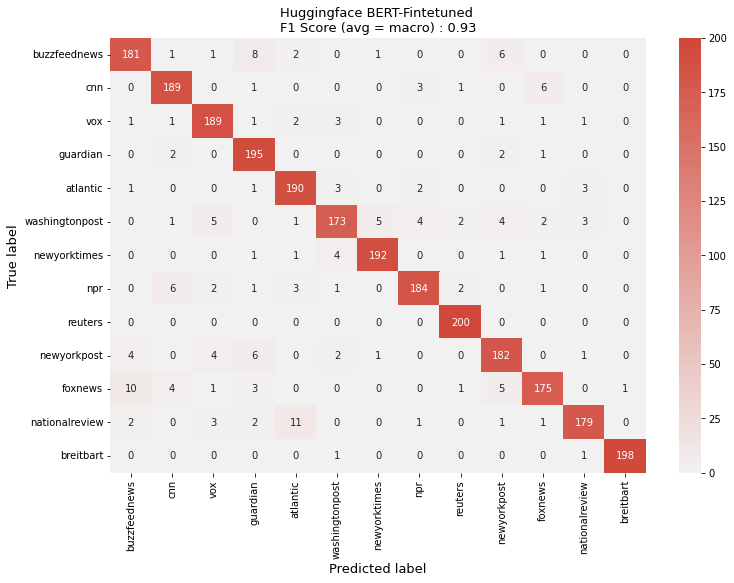

In [36]:
# printing our classifcation report and MCC
print(classification_report(y_true = true_vals_pub_test, y_pred = y_pred_pub_test))
print("Matthews Correlation Coefficient: {}".format(matthews_corrcoef(y_true=true_vals_pub_test, y_pred=y_pred_pub_test)))
print("hamming loss: {}".format(hamming_loss(y_true = true_vals_pub_test, y_pred = y_pred_pub_test)))

# creating our confusion matrix
cm = confusion_matrix(y_true = true_vals_pub_test, 
                      y_pred = y_pred_pub_test
                     )
cm_df = pd.DataFrame(cm,
                     index = ['buzzfeednews','cnn', 'vox',
                              'guardian', 'atlantic', 'washingtonpost',
                              'newyorktimes', 'npr', 'reuters',
                              'newyorkpost', 'foxnews', 'nationalreview',
                              'breitbart'], 
                     columns = ['buzzfeednews','cnn', 'vox',
                                'guardian', 'atlantic', 'washingtonpost',
                                'newyorktimes', 'npr', 'reuters',
                                'newyorkpost', 'foxnews', 'nationalreview',
                                'breitbart']
                    )

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Huggingface BERT-Fintetuned \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(true_vals_pub_test, y_pred_pub_test, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       200
           1       0.95      0.93      0.94       200
           2       0.96      0.99      0.98       200
           3       0.98      0.98      0.98       200
           4       0.97      0.95      0.96       200

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Matthews Correlation Coefficient: 0.9525595368316362
hamming loss: 0.038


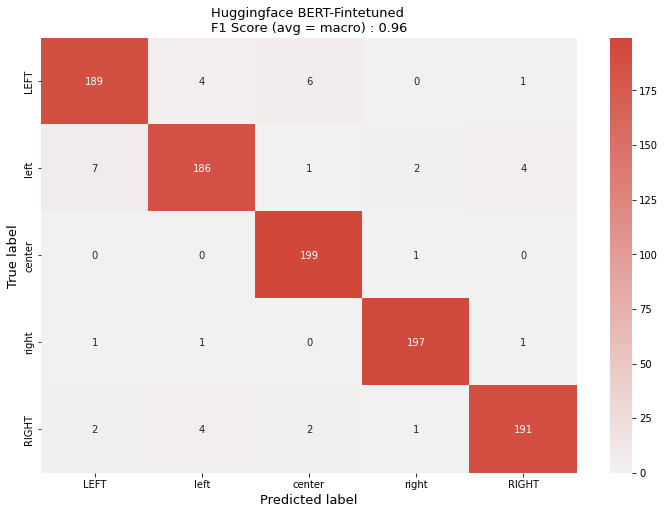

In [37]:
# same as above but for BIAS
print(classification_report(y_true = true_vals_bias_test, y_pred = y_pred_bias_test))
print("Matthews Correlation Coefficient: {}".format(matthews_corrcoef(y_true=true_vals_bias_test, y_pred=y_pred_bias_test)))
print("hamming loss: {}".format(hamming_loss(y_true = true_vals_bias_test, y_pred = y_pred_bias_test)))
cm = confusion_matrix(y_true = true_vals_bias_test, 
                      y_pred = y_pred_bias_test
                     )
cm_df = pd.DataFrame(cm,
                     index = ['LEFT', 'left', 'center', 'right', 'RIGHT'], 
                     columns = ['LEFT', 'left', 'center', 'right', 'RIGHT']
                    )

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Huggingface BERT-Fintetuned \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(true_vals_bias_test, y_pred_bias_test, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()